## Convolutional Neural Networks

Objectives:

*   Construct a CNN using PyTorch
*   Train and evaluate
*   Finetuning a pretrained network

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# To avoid the error URLError:<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_contexta<

In [2]:
#writing our custom dataloader
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import zipfile
import numpy as np
import cv2 as cv

def get_filelist_from_zip(zip_file):
    filelist = []
    with zipfile.ZipFile(zip_file, 'r') as archive:
        infos = archive.infolist()
        for info in infos:
            if(info.file_size == 0):
                continue
            filelist.append(info.filename)
    return filelist

def extract_all_categories_from_path(filelist, categorie_path_pos=1):
    categorie_list = []
    for f in filelist:
        splited_path = f.split("/")
        categorie_name = splited_path[categorie_path_pos]
        # print(categorie_name)
        categorie_list.append(categorie_name)
    return categorie_list

class CustomDataset(Dataset):
    def __init__(self, path_zip, filelist = None):
        self.imgs_path = path_zip
        if filelist is not None:
            file_list = filelist
        else:
             file_list = get_filelist_from_zip(path_zip)
        category_list = extract_all_categories_from_path(file_list, categorie_path_pos=1)
        # print(category_list)
        # print(file_list)
        self.data = []
        for i in range(len(category_list)):
            self.data.append([file_list[i], category_list[i]])
        self.class_map = {}
        for i, clas in enumerate(np.unique(np.array(category_list))):
            self.class_map.update({clas:i})
        self.img_dim = (512, 512)

    def get_classes(self):
        classes = [cl[1] for cl in self.data]
        # print(classes)
        return np.unique(np.array(classes))
    
    def get_class_mapping(self):
        return self.class_map
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        img_path, class_name = data[0], data[1]
        with zipfile.ZipFile(self.imgs_path, 'r') as zfile:
            img = cv.imdecode(np.frombuffer(zfile.read(img_path), np.uint8), cv.IMREAD_COLOR)
            # img = cv.normalize(img, cv.NORM_MINMAX)
            # print(img_path)
            img = (np.float32(img)-np.min(img))/(np.max(img)-np.min(img))
            # img = np.uint8(np.uint8((np.double(img)-np.double(np.min(np.min(img))))*(255/np.double(np.max(np.max(img))-np.min(np.min(img))))))
        # img = cv.imread(img_path)
        img = cv.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [3]:
zip_location = "/home/sebastian/uibk/ss2023/computerVision/assignments/assignment4/data/A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology.zip"
# zip_location = "/home/sebastian/uibk/ss2023/computerVision/assignments/assignment4/data/leafs.zip"

#make the train and test split 
all_files = get_filelist_from_zip(zip_location)

# all_files = [k for k in all_files if 'healthy' in k]
all_files = [k for k in all_files if '.JPG' in k] # fix: 'A Database of Leaf Images Practice towards Plant Conservation with Plant Pathology/Basil (P8)/healthy/.directory' was loaded which isn't an image and causes problems!
# print(all_files)

#size_train = math.floor(factor * size)
splitsize = int(np.ceil((1-0.8) * len(all_files)))
np.random.shuffle(all_files)

test_files = all_files[:splitsize]
train_files = all_files[splitsize:]
print(f'trainset size {len(train_files)} testset size {len(test_files)}')

trainset = CustomDataset(zip_location, train_files)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=11)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testset = CustomDataset(zip_location, test_files)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=11)

# The 10 classes of CIFAR-10
classes = trainset.get_classes()

trainset size 9597 testset size 2400


torch.Size([10, 3, 512, 512])
0.9973215


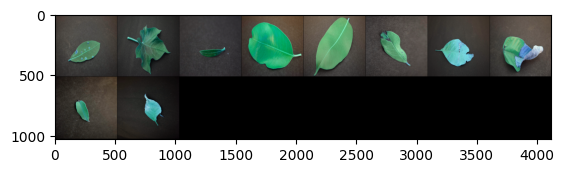

Arjun (P1) Jatropha (P6) Alstonia Scholaris (P2) Jamun (P5)


In [4]:
# Visualizing some sample images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # img = img    # unnormalize
    npimg = img.numpy()
    print(np.max(npimg))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
import torch.nn as nn
import torch.nn.functional as F


In [7]:
# Define the loss and the optimizer

import torch.optim as optim
import datetime

In [8]:
# # Save the trained model
# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

1.0


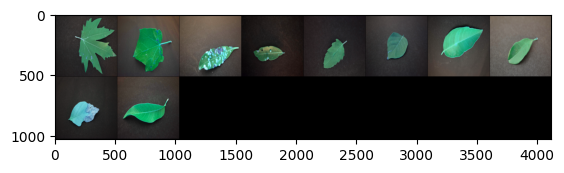

GroundTruth:  Chinar (P11) Jatropha (P6) Alstonia Scholaris (P2) Arjun (P1) Basil (P8) Pongamia Pinnata (P7) Lemon (P10) Pomegranate (P9) Bael (P4) Mango (P0)


In [9]:
# Check the testset

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [10]:
# # Load the saved weights and create the network
# PATH = './cifar_net.pth'
# # net = Net().to(device)
# net.load_state_dict(torch.load(PATH))
# outputs = net(images)
# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                               for j in range(4)))

In [11]:
# # Check the accuracy on the test set

# correct = 0
# total = 0
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data[0].to(device), data[1].to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))

In [12]:
# # Check the accuracy for each class

# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data[0].to(device), data[1].to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1


# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

## Visualizing the Network Structure

In [13]:
# print(net)

In [14]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [15]:
from torchsummary import summary

# summary(net, (3, 32, 32)) # (channels, height, width of input image)

## Finetuning

In [16]:
from torchvision import models
import torch

# Create a resnet network with pretrained weights (trained on ImageNet)
model_resnet = models.resnet18(pretrained=True).to(device)
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/sebastian/uibk/ss2023/computerVision/assignments/venv3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sebastian/uibk/ss2023/computerVision/assignments/venv3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Prevent the trained weights from being modified
for param in model_resnet.parameters():
    param.requires_grad = False

# change first conv layers
# features = list(model_resnet.features.children())
# features.extend([nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)).to(device)])
# features.extend([nn.ReLU(inplace=True).to(device)])

# model_resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)

#model_resnet.conv1.requires_grad_ = True
# Compute the input feature size for the first fc layer
# num_ftrs = list(model_resnet.classifier.children())[0].in_features
# print(num_ftrs)

# last_conv_layer = model_resnet.layer4[-1].conv3
# num_ftrs = last_conv_layer.out_channels
num_ftrs = model_resnet.fc.in_features
# print(num_ftrs)

# Create a new set of fc layers
classifier = [
    nn.Linear(in_features=num_ftrs, out_features=400).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=400, out_features=300).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=300, out_features=200).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=200, out_features=100).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=100, out_features=50).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=50, out_features=len(classes), bias=True).to(device),
]

for m in classifier:
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="leaky_relu")

# model_vgg16.features = nn.Sequential(*features)
# model_resnet.fc = nn.Sequential(*classifier)
model_resnet.fc = nn.Sequential(*classifier) # Replace the model classifier
# print(model_resnet)

In [18]:
summary(model_resnet, (3, 32, 32)) # Input size: (channels, height, width of image)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [19]:
# Define the loss and the optimizer
epochs=20


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-3, weight_decay=1e-4)
#optimizer_2 = optim.Adam(model_resnet.parameters(), lr=0.00001, weight_decay=1e-4)
#sched = torch.optim.lr_scheduler.OneCycleLR(optimizer_1, max_lr=0.0001, epochs=epochs, steps_per_epoch=len(trainloader))

# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
# scheduler = CosineAnnealingWarmRestarts(optimizer, 
#                                         T_0 = 6,# Number of iterations for the first restart
#                                         T_mult = 1, # A factor increases TiTi​ after a restart
#                                         eta_min = 1e-6) # Minimum learning rate
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [20]:
import datetime


starttime = datetime.datetime.now()

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    model_resnet.train()
    train_accuracy = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].squeeze(1).to(device)
        # print(inputs.shape)
        # print(data[1].squeeze(1).shape)
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
                train_accuracy += (torch.argmax(outputs, dim=1) == labels).sum()
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            print(datetime.datetime.now() - starttime)
            starttime = datetime.datetime.now()
            print(f'\nTraining accuracy: {100*train_accuracy/len(trainloader.dataset):.2f}\n')
    # scheduler.step()
print('Finished Training')

PATH = './resnet_trained.pth'
torch.save(model_resnet.state_dict(), PATH)

[1,   200] loss: 0.248
0:01:39.495265

Training accuracy: 5.13

[1,   400] loss: 0.145
0:01:34.266887

Training accuracy: 16.06

[1,   600] loss: 0.107
0:01:34.911647

Training accuracy: 29.52

[1,   800] loss: 0.094
0:01:36.670663

Training accuracy: 43.96

[2,   200] loss: 0.069
0:02:49.070047

Training accuracy: 16.40

[2,   400] loss: 0.067
0:01:36.914136

Training accuracy: 32.65

[2,   600] loss: 0.063
0:01:29.689652

Training accuracy: 49.17

[2,   800] loss: 0.060
0:01:32.125324

Training accuracy: 66.08

[3,   200] loss: 0.048
0:02:47.820698

Training accuracy: 17.71

[3,   400] loss: 0.054
0:01:32.282727

Training accuracy: 35.06

[3,   600] loss: 0.049
0:01:30.095068

Training accuracy: 52.69

[3,   800] loss: 0.039
0:01:35.529719

Training accuracy: 70.85

[4,   200] loss: 0.039
0:02:48.057396

Training accuracy: 18.29

[4,   400] loss: 0.043
0:01:32.578545

Training accuracy: 36.40

[4,   600] loss: 0.042
0:01:31.108956

Training accuracy: 54.53

[4,   800] loss: 0.037
0:0

In [20]:
from torchvision import models
PATH = 'resnet_trained94percentAugmented.pth'
print(device)
device = ('cpu')
model_resnet = models.resnet18(pretrained=False).to(device)

num_ftrs = model_resnet.fc.in_features

classifier = [
    nn.Linear(in_features=num_ftrs, out_features=400).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=400, out_features=300).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=300, out_features=200).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=200, out_features=100).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=100, out_features=50).to(device),
    nn.LeakyReLU(inplace=True).to(device),
    nn.Linear(in_features=50, out_features=len(classes), bias=True).to(device),
]

model_resnet.fc = nn.Sequential(*classifier) 

# model_resnet.load_state_dict(torch.load(PATH))

#run this instead if cuda is not availabe
model_resnet.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

cuda:0


/home/sebastian/uibk/ss2023/computerVision/assignments/venv3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [21]:
# Check the accuracy of the finetuned network on the test set

correct = 0
total = 0

ytrue = []
ypred = []


with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        ytrue.append(data[1].detach().cpu().numpy().squeeze())
        ypred.append(predicted.detach().cpu().numpy())
        # print(f'{labels}')
        # print(f'{predicted}')
        
        correct += (predicted == labels.squeeze()).sum().item()
        # print(correct)
        # print((predicted == labels))
        # print((predicted == labels.squeeze()))
        # break

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print(f'num correct {correct} num total {total}')

Accuracy of the network on the 10000 test images: 95 %
num correct 2298 num total 2400


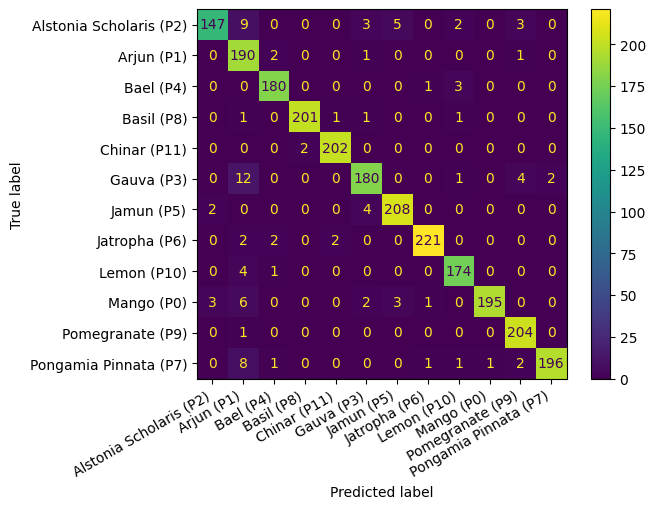

In [22]:
#generate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ypred_new = np.array([])
ytrue_new = np.array([])

for pred, true in zip(ypred, ytrue):
    if np.array(true).shape == ():
        true = [true]
    ypred_new = np.concatenate((ypred_new, np.array(pred)))
    ytrue_new = np.concatenate((ytrue_new, np.array(true)))


# ytrue = np.array(ytrue).squeeze().flatten()
# ypred = np.array(ypred).squeeze().flatten()
classmapping = testset.get_class_mapping()
a = list(classmapping.keys())

cm = confusion_matrix(ytrue_new, ypred_new)

disp = ConfusionMatrixDisplay(cm, display_labels=a)

disp.plot()
plt.xticks(rotation=30, ha='right')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


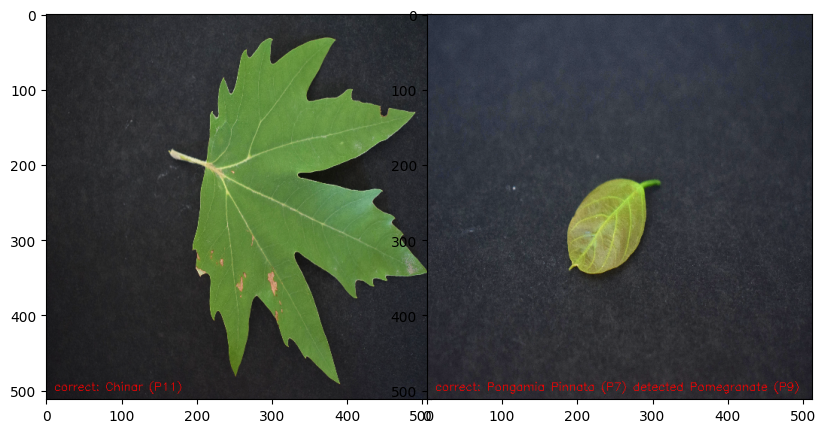

In [23]:
import matplotlib.pyplot as plt
correct = []
incorrect = []
stop = 0
classmapping = testset.get_class_mapping()
reverse_classmapping = dict((v, k) for k, v in classmapping.items())
with torch.no_grad():
    for data in testloader:
        if stop == 1:
            break
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(images)):
            if labels[i] == predicted[i] and len(correct) == 0:
                correct.append((images[i],predicted[i]))
            if labels[i] != predicted[i] and len(incorrect) == 0:
                incorrect.append((images[i],labels[i], predicted[i]))
            if len(correct) == 1 and len(incorrect) == 1:
                stop = 1
                break

print(correct[0][0].permute(1,2,0).cpu().numpy().shape)

imgcorrect = correct[0][0].permute(1,2,0).cpu().numpy()
imgcorrect = cv.cvtColor(imgcorrect, cv.COLOR_RGB2BGR)

imgincorrect = incorrect[0][0].permute(1,2,0).cpu().numpy()
imgincorrect = cv.cvtColor(imgincorrect, cv.COLOR_RGB2BGR)

detectedclass = reverse_classmapping[int(incorrect[0][2].cpu().numpy())]
correctclass = reverse_classmapping[int(incorrect[0][1].cpu().numpy())]
textincorrect = f'correct: {correctclass} detected {detectedclass}'

textcorrect = f'correct: {reverse_classmapping[int(correct[0][1].cpu().numpy())]}'

correct_with_text = cv.putText(imgcorrect, textcorrect, (10,500), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv.LINE_AA)
incorrect_with_text = cv.putText(imgincorrect, textincorrect, (10,500), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv.LINE_AA)

fig = plt.figure(2, figsize=(18, 5))
fig.add_subplot(1, 1, 1)
plt.imshow(correct_with_text)
fig.add_subplot(1, 2, 2)
plt.imshow(incorrect_with_text)

plt.show()

In [24]:
reverse_classmapping = dict((v, k) for k, v in classmapping.items())
print(reverse_classmapping[int(correct[0][1].cpu().numpy())])



Chinar (P11)


In [25]:
%pip install pandas seaborn scipy

Note: you may need to restart the kernel to use updated packages.


In [40]:
# https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # print(f'{y_real} TP {TP} FP {FP} TN {TN} FN {FN}')

    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr, TN, FP, FN, TP


def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    TN, FP, FN, TP = 0,0,0,0

    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr, tn, fp, fn, tp = calculate_tpr_fpr(y_real, y_pred)
        TN += tn
        FP += fp
        FN += fn
        TP += tp
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    print(f'all TN {TN} FP {FP} FN {FN} TP {TP}')
    return tpr_list, fpr_list


def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


In [43]:
testdata = []
testlabels = []
yproba = []
for i in range(400):#testset.__len__()
    Xtest, ytest = testset.__getitem__(i)
    testdata.append(Xtest)
    testlabels.append(ytest)
    # print(Xtest)

model_resnet.eval()
yproba = model_resnet(torch.stack(testdata))
# yproba = F.softmax(logits, dim=1) # assuming logits has the shape [batch_size, nb_classes]
ypred = torch.argmax(yproba, dim=1)

# print(torch.argmax(probs[0]))

KeyboardInterrupt: 

all TN 79326 FP 69474 FN 474 TP 10726
all TN 78863 FP 69537 FN 937 TP 10663
all TN 78932 FP 64268 FN 868 TP 15932
all TN 79180 FP 67220 FN 620 TP 12980
all TN 79365 FP 68635 FN 435 TP 11565
all TN 79164 FP 69236 FN 636 TP 10964
all TN 79007 FP 64993 FN 793 TP 15207
all TN 79019 FP 64981 FN 781 TP 15219
all TN 79500 FP 70500 FN 300 TP 9700
all TN 79003 FP 65397 FN 797 TP 14803
all TN 79302 FP 67898 FN 498 TP 12302
all TN 79048 FP 68152 FN 752 TP 12048


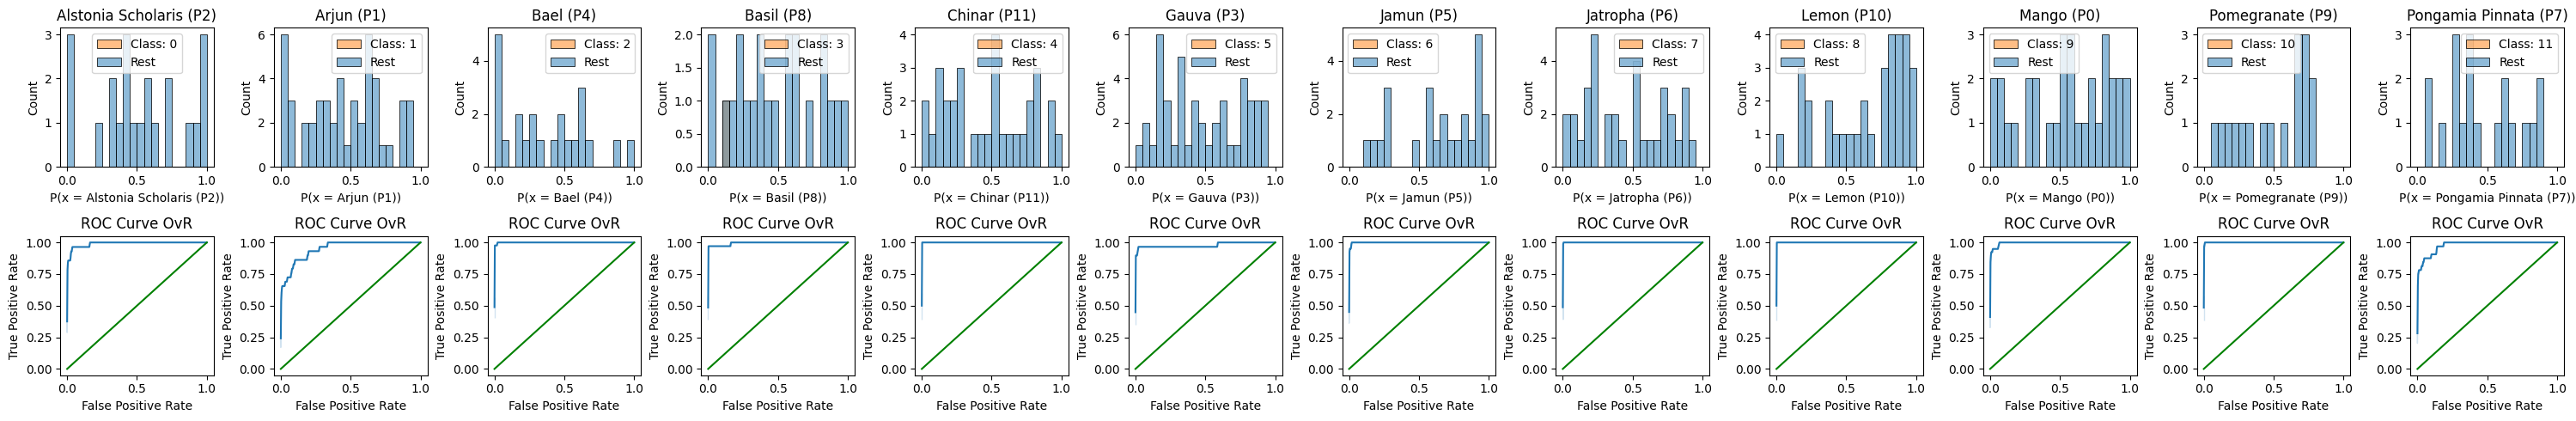

In [41]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (30, 5))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

classes = [0,1,2,3,4,5,6,7,8,9,10,11]

for i in range(len(classes)):
    # Gets the class
    c = classes[i]
    
    # Prepares an auxiliar dataframe to help with the plots
    # df_aux = testdata.copy()
    df_aux = pd.DataFrame([], columns=['class', 'prob'])
    # print(df_aux)
    # print(f'c {c} testlabels[0] {testlabels.numpy()[0]}')
    df_aux['class'] = [1 if y.numpy()[0] == c else 0 for y in testlabels]
    df_aux['prob'] = yproba.detach().numpy()[:, i]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 12, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(reverse_classmapping[c])
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {reverse_classmapping[c]})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 12, i+13)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")
    
    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    
plt.tight_layout()

## Things to try


*   Improve the accuracy of the network trained from scratch:
    *    Deeper network (move convolutional layers, more fc layers)
    *    Try a different optimizer such as Adam or RMSprop
    *    Use a different or decaying learning rate
*   Improve the accuracy of the finetuned model
    *    Tune conv layers in addition to the fc layers
    *    Instead of replacing all fc layers, replace the last one
    *    Train for more epochs
    *    Try out different batch sizes, optimizers, learning rates
    *    Finetune a different network such as AlexNet or ResNet
*   Visualize filter (kernel) weights
*   Visualize activations